### Installing and Importing Libraries

Let's begin by installing and importing the necessary libraries to run this notebook as well as changing some settings to be able to easily visualize our data.

In [103]:
# Import standard packages to be used
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
import os
import glob
import string
from PIL import Image
import urllib.request

# Import standard packages for Natural Language Processing
import nltk
from nltk import FreqDist, word_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

# Importa SciKit Learn packages for modeling and model evaluation
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.metrics import plot_confusion_matrix, roc_curve

# Magic function to display plots in notebook
%matplotlib inline

### Importing Data

now we directly upload data which downloaded diectly from code provided in class materials.

In [104]:
df = pd.read_csv('Medi_40.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOH9ZsJE2TcOLFtfvJgS1DzgOfBWUQFm7wQ7aP_...,Calum Adams,https://play-lh.googleusercontent.com/a-/AOh14...,Charing people to manage their mental health i...,1,0,5.36,2022-04-05 15:40:35,NaN,NaN,newest,com.calm.android
1,gp:AOqpTOGeo2bhqE7M0IYrlHonThb6wtRLNrGRasZed5o...,Lovely Toblerone,https://play-lh.googleusercontent.com/a-/AOh14...,Immediately asks for money. Calming,1,0,NaN,2022-04-05 08:35:54,NaN,NaN,newest,com.calm.android
2,gp:AOqpTOFT3ZtIwOm_dX6dslKO5ykS-3QCKy_SMgSE0cE...,Xavier Gamez,https://play-lh.googleusercontent.com/a-/AOh14...,Paywall,1,0,NaN,2022-04-05 08:02:38,NaN,NaN,newest,com.calm.android
3,gp:AOqpTOHjOsk6BjXevjWxA-8Bqa-WIiYYK6nmk6f-gbD...,Officer Love,https://play-lh.googleusercontent.com/a-/AOh14...,Want to do anything useful like listen to trai...,1,0,5.37,2022-04-05 07:28:48,NaN,NaN,newest,com.calm.android
4,gp:AOqpTOHWLblLKJK57Mmke5sz_2FaG0bwzhFqYiuJp7o...,MaryAnne Viola,https://play-lh.googleusercontent.com/a-/AOh14...,This app sucks! What a rip off! It claims to b...,1,0,NaN,2022-04-05 06:02:38,NaN,NaN,newest,com.calm.android


## Data Preparation

In [105]:
# Check for null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43088 entries, 0 to 43087
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              43088 non-null  object
 1   userName              43088 non-null  object
 2   userImage             43088 non-null  object
 3   content               43083 non-null  object
 4   score                 43088 non-null  int64 
 5   thumbsUpCount         43088 non-null  int64 
 6   reviewCreatedVersion  34209 non-null  object
 7   at                    43088 non-null  object
 8   replyContent          6965 non-null   object
 9   repliedAt             6965 non-null   object
 10  sortOrder             43088 non-null  object
 11  appId                 43088 non-null  object
dtypes: int64(2), object(10)
memory usage: 3.9+ MB


### Pre Process

We begin the exploration phase by examining the distribution of ratings and review counts across the apps.

In [106]:
# Check distribution of ratings across all apps in percentages
df['score'].value_counts(normalize=True)

5    0.278500
4    0.220340
1    0.189032
2    0.164895
3    0.147234
Name: score, dtype: float64

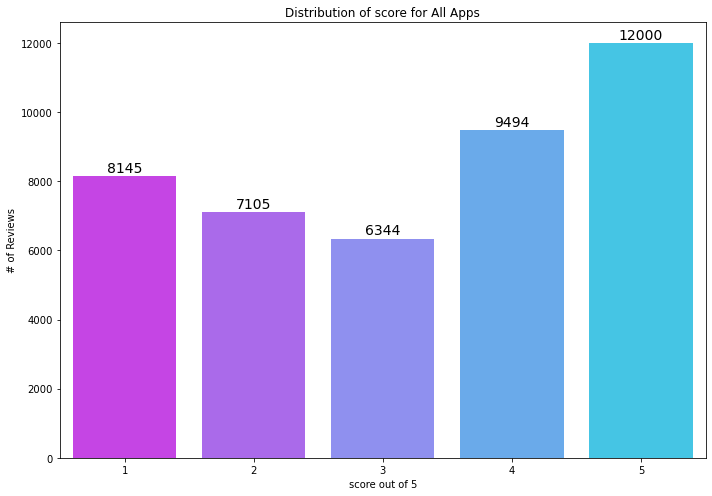

In [107]:
# Plot distribution of ratings across all apps
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='score', data=df, ax=ax, palette='cool_r')
ax.set_title('Distribution of score for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('score out of 5')

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

In [108]:
# drop unsused columns
df = pd.DataFrame(df, columns=['content','score'])
df.head()

,content,score
0,Charing people to manage their mental health i...,1
1,Immediately asks for money. Calming,1
2,Paywall,1
3,Want to do anything useful like listen to trai...,1
4,This app sucks! What a rip off! It claims to b...,1


In [109]:
# Pre-processing steps for data

df['content'] = [re.sub('\s*@\s*\s?', ' ', str(sent)) for sent in df['content']]

df['content'] = [re.sub('\?', ' ', str(sent)) for sent in df['content']]

df['content'] = [re.sub('\_', ' ', str(sent)) for sent in df['content']]

df['content'] = [re.sub('@"[\d-]"', ' ', str(sent)) for sent in df['content']]

# Remove new line characters
df['content'] = [re.sub('\s+', ' ', str(sent)) for sent in df['content']]

# Remove distracting single quotes
df['content'] = [re.sub("\'", " ", str(sent)) for sent in df['content']]

#Converting into lowercase
df['content']=df['content'].str.lower()

# Emojis pattern
def remove_emojis(data):
  emoj= re.compile('['
                u'\U0001F600-\U0001F64F'  # emoticons
                u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                u'\U0001F680-\U0001F6FF'  # transport & map symbols
                u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
                u'\U00002702-\U000027B0'
                u'\U000024C2-\U0001F251'
                u'\U0001f926-\U0001f937'
                u'\U00010000-\U0010ffff'
                u'\u200d'
                u'\u2640-\u2642'
                u'\u2600-\u2B55'
                u'\u23cf'
                u'\u23e9'
                u'\u231a'
                u'\u3030'
                u'\ufe0f'
    ']+', flags=re.UNICODE)
  return re.sub(emoj, '', data)

In [110]:
df['content'] = df['content'].apply(remove_emojis)

#### Multi-Class Sentiments

In [128]:
# Make new multiclass sentiment column based on rating
# 4 and above are positive, 3 is neutral, 1-2 are negative
conditions = [df['score'] >= 4,
              df['score'] == 3,
              df['score'] <= 2,]
values = [2, 1, 0]

df['multi_sent'] = np.select(conditions, values)

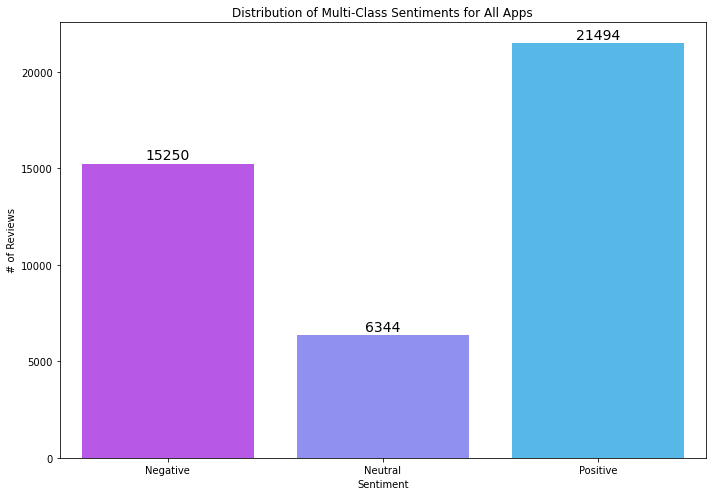

In [129]:
# Plot distribution of multiclass sentiments across all apps
fig, ax = plt.subplots(figsize=(10,7))

sns.countplot(x='multi_sent', data=df, ax=ax, palette='cool_r')

ax.set_title('Distribution of Multi-Class Sentiments for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Sentiment')
ax.set_xticklabels(['Negative','Neutral', 'Positive'])

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

#### Binary Sentiments

In [130]:
# Make new binary sentiment column based on ratings
# 3 and above are positive, below 3 is negative
conditions = [df['score'] >= 3,
              df['score'] < 3]

values = [1,0]

df['sent_bin_3up'] = np.select(conditions, values)

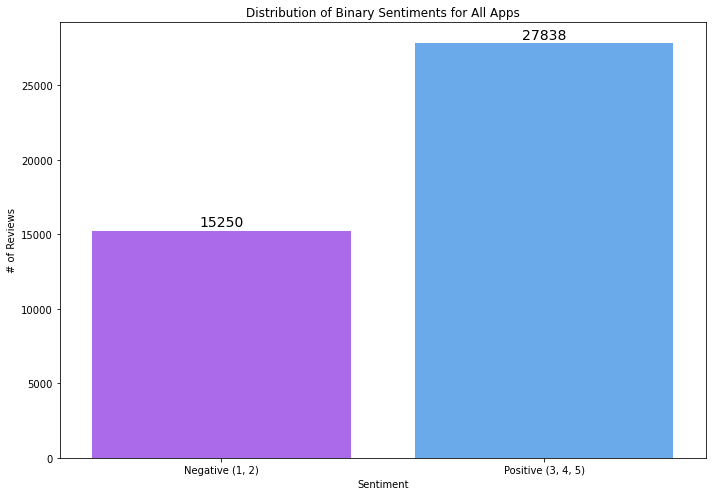

In [131]:
# Plot distribution of binary sentiments across all apps
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='sent_bin_3up', data=df, ax=ax, palette='cool_r')
ax.set_title('Distribution of Binary Sentiments for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Sentiment')
ax.set_xticklabels(['Negative (1, 2)', 'Positive (3, 4, 5)'])

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

In [132]:
## Make new binary sentiment column based on ratings 4 and up
conditions = [
    df['score'] >= 4,
    df['score'] < 4,
]

values = [1,0]

df['sent_bin_4up'] = np.select(conditions, values)

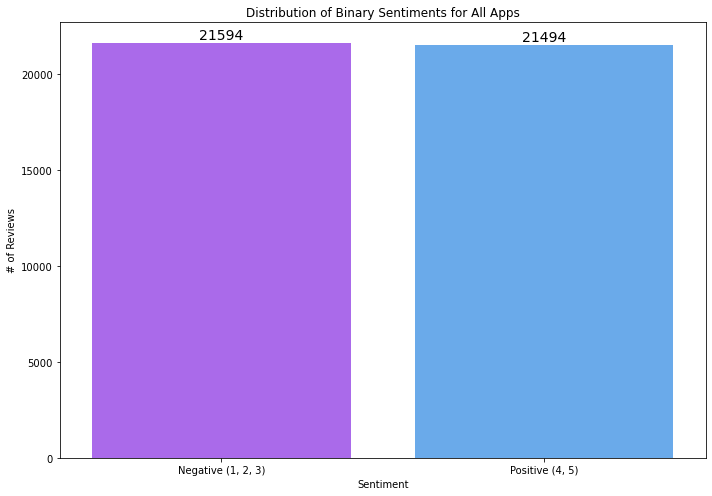

In [133]:
# Plot distribution of binary sentiments across all apps
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='sent_bin_4up', data=df, ax=ax, palette='cool_r')
ax.set_title('Distribution of Binary Sentiments for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Sentiment')
ax.set_xticklabels(['Negative (1, 2, 3)', 'Positive (4, 5)'])

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

We can see a large class imbalance between Negative and Positive for both splits. However, during the modeling trials, it was found that the 1-3, 4-5 split performed slightly better than the 1-2, 3-5 split on all model types. Therefore, we will proceed with the 1-3, 4-5 split, since the insights we can gain from a more accurate model will be more powerful than from a less accurate one.

In [134]:
# Slice out relevant columns into a new dataframe
clean_df = df[['content', 'score', 'multi_sent', 
               'sent_bin_3up', 'sent_bin_4up']]
clean_df

,content,score,multi_sent,sent_bin_3up,sent_bin_4up
0,charing people manage mental health ok min dai...,1,0,0,0
1,immediately asks money calming,1,0,0,0
2,paywall,1,0,0,0
3,want anything useful like listen trains nature...,1,0,0,0
4,app sucks rip claims free,1,0,0,0
...,...,...,...,...,...
43083,greatest meditation round app free meditation ...,5,2,1,1
43084,good,5,2,1,1
43085,find app wonderful chose many parameters find ...,5,2,1,1
43086,love learning options app wide variety teacher...,5,2,1,1


In [135]:
# Create a single corpus out of all combined text
corpus = clean_df['content'].to_list()

# Convert Corpus to Tokens
tokens = regexp_tokenize(','.join(corpus), r"([a-zA-Z]+(?:’[a-z]+)?)")

# Preview tokens
tokens[:20]

['charing',
 'people',
 'manage',
 'mental',
 'health',
 'ok',
 'min',
 'daily',
 'meditation',
 'premium',
 'makes',
 'sick',
 'charge',
 'immediately',
 'asks',
 'money',
 'calming',
 'paywall',
 'want',
 'anything']

In [136]:
# Check number of unique tokens
len(set(tokens))

18451

## Lemmatization

In [137]:
# Lemmatizing function for list of tokens
def lemmatize_tokens(tokens_list):
    """
    Lemmatizes list of string trokens and returns list of lemmatized
    string tokens.

    Args:
        tokens_list (list) : List of string tokens to be lemmatized.

    Returns:
        tokens_lemm (list) : List of lemmatized string tokens
    """
    
    lemmatizer = WordNetLemmatizer()
    tokens_lemm = [lemmatizer.lemmatize(word) for word in tokens_list]
    return tokens_lemm

In [138]:
# Lemmatize tokens
nltk.download('wordnet')
lemmatized_tokens = lemmatize_tokens(tokens)

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [139]:
# Check number of unique tokens after lemmatization
len(set(lemmatized_tokens))

16834

Our lemmatization function has reduced the number of unique tokens by a little over 2000 words.

## Stopword Removal


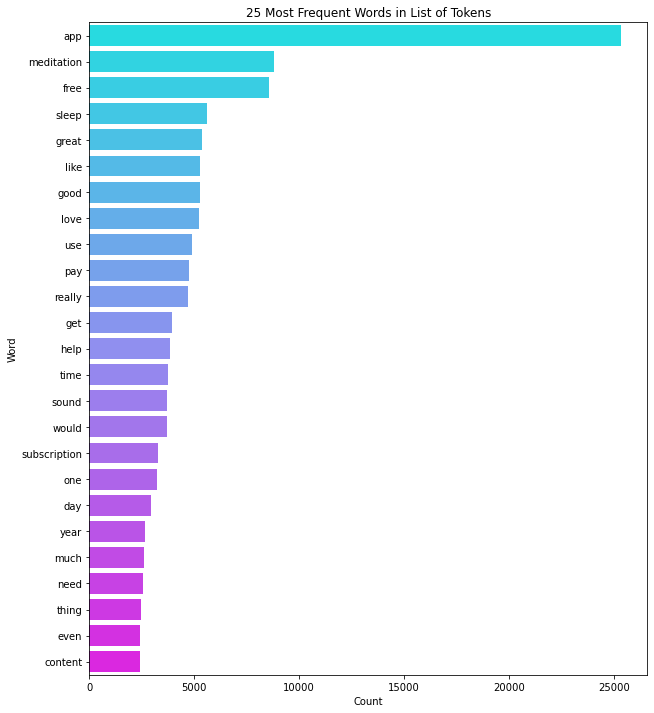

In [140]:
# Write function to create barplot of most common words
def most_freq(tokens, n=25, figsize=(12,7)):
    """
    Displays bar plot of n most frequent words in a list of tokens.

    Args:
        tokens (list) : List of string tokens to plot frequency for.
        n (int) : Number of tokens to plot.
        figsize (float, float) : Width, height in inches.

    Returns:
        
    """
    # Get frequency distribution of list of tokens
    freq = FreqDist(tokens)
    
    # Convert to DataFrame
    most_frequent_tokens = pd.DataFrame(freq.most_common(n),
                           columns=['word','count']).sort_values('count', 
                                                                 ascending=False)

    # Plot frequency distribution
    fig, ax = plt.subplots(figsize=(10,12))
    
    sns.barplot(data=most_frequent_tokens, y='word', x='count', 
                palette='cool', ax=ax, orient='h')

    ax.set_title(f'{n} Most Frequent Words in List of Tokens')
    ax.set_ylabel('Word')
    ax.set_xlabel('Count')
    
    
# Display frequency distirbution of lemmatized tokens
most_freq(lemmatized_tokens)

In [141]:
# Get all the stop words in the English language and preview first 25
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
stopwords_list[:25]

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers']

In [142]:
# Add punctuation to stopwords_list
stopwords_list.extend(string.punctuation)
stopwords_list[-10:]

['[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

In [143]:
# Add additional punctuation below to stopwords_list
stopwords_list.extend(['“','”','...',"''",'’','``'])

In [144]:
# Remove stopwords from list of tokens
stopped_tokens = [w.lower() for w in lemmatized_tokens  if w.lower() \
                  not in stopwords_list]
stopped_tokens[:50]

['charing',
 'people',
 'manage',
 'mental',
 'health',
 'ok',
 'min',
 'daily',
 'meditation',
 'premium',
 'make',
 'sick',
 'charge',
 'immediately',
 'asks',
 'money',
 'calming',
 'paywall',
 'want',
 'anything',
 'useful',
 'like',
 'listen',
 'train',
 'nature',
 'sound',
 'pay',
 'money',
 'say',
 'click',
 'x',
 'free',
 'trial',
 'free',
 'stuff',
 'barried',
 'somewhere',
 'know',
 'tho',
 'listen',
 'use',
 'anything',
 'useful',
 'app',
 'behind',
 'pay',
 'wall',
 'app',
 'suck',
 'rip']

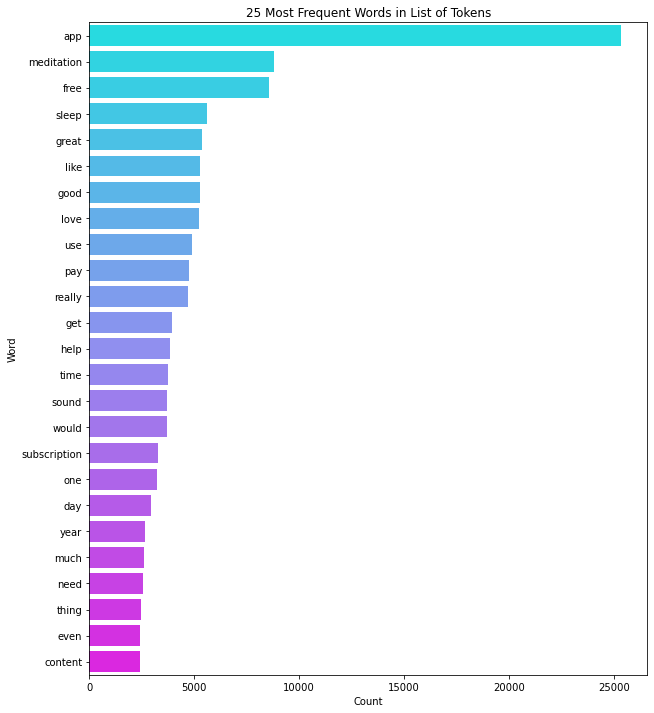

In [145]:
# Display frequency distirbution of lemmatized tokens after removing stopwords
most_freq(stopped_tokens, 25, figsize=(12,40))

Now that we have removed common stopwords, we begin to see more insightful words. However, we can continue to remove some words that provide no value toward differentiating between negative, positive and neutral sentiments, including the word "app" and the common app names.

In [146]:
# Add common words unrelated to sentiment to stopwords_list
stopwords_list.extend(["app","wa", "ha", "apps", "headspace", "meditation", 
                       "thing", "timer", "one", "thing","would"])

In [147]:
# Remove new stopwords
stopped_tokens = [w.lower() for w in lemmatized_tokens  if w.lower() \
                  not in stopwords_list]
stopped_tokens[:50]

['charing',
 'people',
 'manage',
 'mental',
 'health',
 'ok',
 'min',
 'daily',
 'premium',
 'make',
 'sick',
 'charge',
 'immediately',
 'asks',
 'money',
 'calming',
 'paywall',
 'want',
 'anything',
 'useful',
 'like',
 'listen',
 'train',
 'nature',
 'sound',
 'pay',
 'money',
 'say',
 'click',
 'x',
 'free',
 'trial',
 'free',
 'stuff',
 'barried',
 'somewhere',
 'know',
 'tho',
 'listen',
 'use',
 'anything',
 'useful',
 'behind',
 'pay',
 'wall',
 'suck',
 'rip',
 'claim',
 'free',
 'everything']

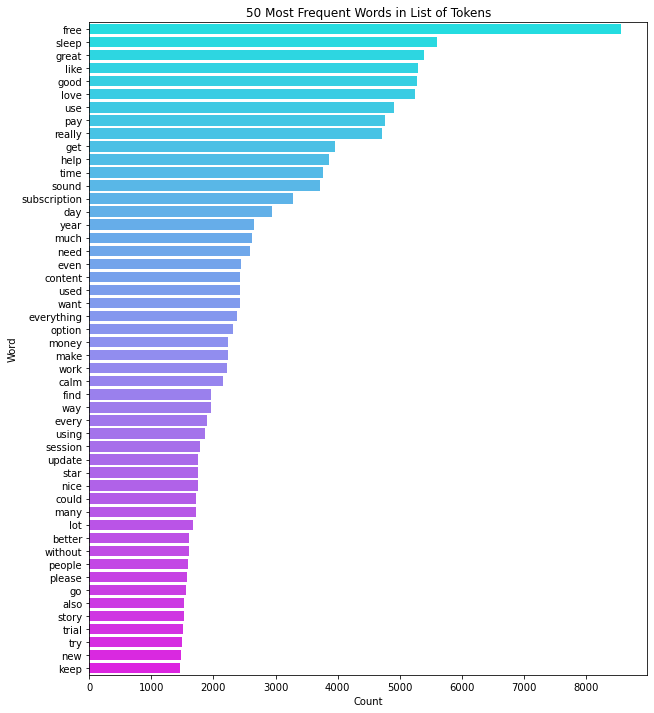

In [148]:
# Display list of tokens after removing extended stopwords
most_freq(stopped_tokens,50, figsize=(12,25))

The words that we have left are much more insightful, but we also want to remove words that are too indicative of the user's sentiment. By doing so, we will be able to better examine what elements of the apps users considered to be negative or positive without obvious indicator words.

The words that are added to the stopword list here have been determined after an initial iteration of the modeling process, where obvious words were taking away from our insights regarding app characteristics.

In [149]:
# Add obvious indicator words to stopwords list
stopwords_list.extend(["good", "love", "best", "amazing", "great", "awesome",
                       "perfect", "fabulous", "wonderful", "excellent", 
                       "helps", "helped", "helpful", "helping", "loving", 
                       "beautiful", "favorite", "fantastic", "calm", "good", 
                       "nice", "stupid", "annoying", "hate", "awful", "worse", 
                       "worst", "terrible", "disappointed", "disappointing", 
                       "garbage", "recommend", "thanks", "thank", "horrible", 
                       "like", "it's", "i'm","omg", "really", "like", "bad","work",
                       "even","get","want","nan","de","la","op","bien","gg","e","ok",
                       "eh","okay","go"])

In [150]:
# Remove stopwords
stopped_tokens = [w.lower() for w in lemmatized_tokens  if w.lower() \
                  not in stopwords_list]

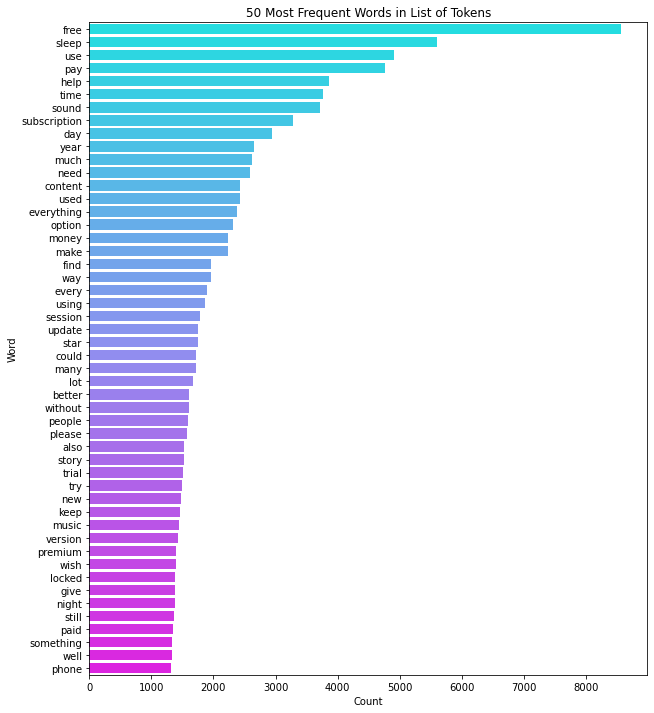

In [151]:
# Display frequency distribution of clean list of tokens
most_freq(stopped_tokens,50, figsize=(12,25))

## Bigram Exploration
Here, we will briefly look at whether there might be combinations of words that might give us more insight into sentiment than single words.

In [152]:
# Get bigrams and frequencies from list of stopped tokens
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
bigram_scores = bigram_finder.score_ngrams(bigram_measures.raw_freq)

In [153]:
# Make a DataFrame from the bigram frequencies
pd.DataFrame(bigram_scores, columns=["Word","Freq"]).head(20)

,Word,Freq
0,"(free, trial)",0.001922
1,"(fall, asleep)",0.001752
2,"(help, sleep)",0.001644
3,"(sleep, story)",0.001349
4,"(free, version)",0.001181
5,"(free, content)",0.001128
6,"(everything, locked)",0.001110
7,"(please, fix)",0.000873
8,"(every, night)",0.000838
9,"(easy, use)",0.000820


It's clear that there are some quite insightful combinations of words. Sleep seems to be a recurring topic in these bigrams, and we can begin to see that this is one element of a mental health app that we would want to consider allocating resources toward developing. Because bigrams have been seen to be insightful, we will keep note of this as we approach the modeling phase.

Let's move on to examine whether Pointwise Mutual Information scores of our bigrams reveal any insight.

In [154]:
# Get bigrams and PMI scores from list of stopped tokens
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_pmi_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
bigram_pmi_finder.apply_freq_filter(3)
bigram_pmi_scored = bigram_pmi_finder.score_ngrams(bigram_measures.pmi)

In [155]:
# Make a DataFrame from the bigram PMI scores
pd.DataFrame(bigram_pmi_scored,columns=['Words','PMI']).head(20)

,Words,PMI
0,"(rege, jean)",17.143496
1,"(kenneth, soares)",16.728459
2,"(nat, rlich)",16.728459
3,"(babbling, brook)",16.728459
4,"(jerome, flynn)",16.406531
5,"(north, cube)",16.406531
6,"(peppa, pig)",16.406531
7,"(wel, wel)",16.084602
8,"(banana, republic)",15.991493
9,"(grind, teeth)",15.991493


Compared to bigram frequencies, PMI scores do not appear to offer much additional insight.

Let's move on to creating wordclouds for our different sentiments.

## WordCloud Visualization
At this point, we have all the parts we need in order to clean up a corpus and create a wordcloud. By creating a wordcloud, we can easily visualize what words are associated with certain sentiments.

Let's begin by previewing a wordcloud for all reviews, with only our final list of stopwords removed.

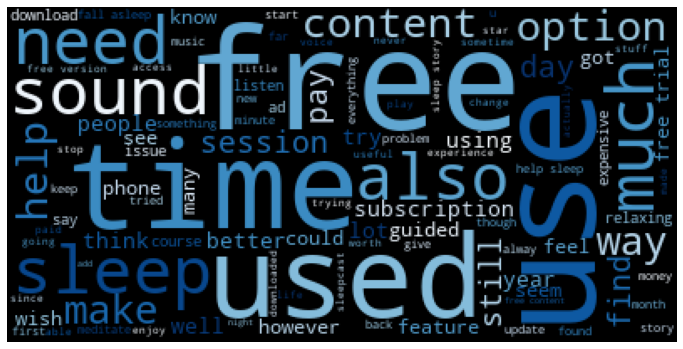

In [156]:
# Create a WordCloud with our stopwords_list and include bigrams
wordcloud = WordCloud(stopwords=stopwords_list,collocations=True, 
                      colormap='Blues', background_color="Black")

# Generate wordcloud from stopped_tokens
wordcloud.generate(','.join(stopped_tokens))

# Plot with matplotlib
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off');

This wordcloud provides us with words that are commonly mentioned in reviews, but it doesn't really tell us much about the sentiments.

In order to get a better idea of what words are associated with different sentiments, we will need to create a few different DataFrames.

### Preparing for WordCloud Generation

In [157]:
# Create and display DataFrames for multi-class sentiments
multi_pos_df = clean_df[clean_df['multi_sent']==2]
multi_neut_df = clean_df[clean_df['multi_sent']==1]
multi_neg_df = clean_df[clean_df['multi_sent']==0]
display(multi_neg_df, multi_neut_df, multi_pos_df)

,content,score,multi_sent,sent_bin_3up,sent_bin_4up
0,charing people manage mental health ok min dai...,1,0,0,0
1,immediately asks money calming,1,0,0,0
2,paywall,1,0,0,0
3,want anything useful like listen trains nature...,1,0,0,0
4,app sucks rip claims free,1,0,0,0
...,...,...,...,...,...
37204,like bell sound rings,2,0,0,0
37205,nice sound put repeat st ring,2,0,0,0
37206,hear bell unless purchase full application,2,0,0,0
37207,considered buying full version however lite ve...,2,0,0,0


,content,score,multi_sent,sent_bin_3up,sent_bin_4up
6000,home screen thing app would recommend pay ever...,3,1,1,0
6001,love app however price way expensive afford thank,3,1,1,0
6002,okay share review,3,1,1,0
6003,check fixes check scheduled pm always happen l...,3,1,1,0
6004,still unsure app,3,1,1,0
...,...,...,...,...,...
38165,know app came happy find stars update latest a...,3,1,1,0
38166,ok free,3,1,1,0
38167,wonder buy full version use facebook connect f...,3,1,1,0
38168,good,3,1,1,0


,content,score,multi_sent,sent_bin_3up,sent_bin_4up
8500,great wonderful app keep calm,4,2,1,1
8501,calm relax sleep well love music phone good time,4,2,1,1
8502,common quite relaxing,4,2,1,1
8503,knew use app,4,2,1,1
8504,calm app several years loved first still use r...,4,2,1,1
...,...,...,...,...,...
43083,greatest meditation round app free meditation ...,5,2,1,1
43084,good,5,2,1,1
43085,find app wonderful chose many parameters find ...,5,2,1,1
43086,love learning options app wide variety teacher...,5,2,1,1


In [158]:
# Create and display DataFrames for binary sentiments
bin_pos_df = clean_df[clean_df['sent_bin_4up']==1]
bin_neg_df = clean_df[clean_df['sent_bin_4up']==0]
display(bin_neg_df, bin_pos_df)

,content,score,multi_sent,sent_bin_3up,sent_bin_4up
0,charing people manage mental health ok min dai...,1,0,0,0
1,immediately asks money calming,1,0,0,0
2,paywall,1,0,0,0
3,want anything useful like listen trains nature...,1,0,0,0
4,app sucks rip claims free,1,0,0,0
...,...,...,...,...,...
38165,know app came happy find stars update latest a...,3,1,1,0
38166,ok free,3,1,1,0
38167,wonder buy full version use facebook connect f...,3,1,1,0
38168,good,3,1,1,0


,content,score,multi_sent,sent_bin_3up,sent_bin_4up
8500,great wonderful app keep calm,4,2,1,1
8501,calm relax sleep well love music phone good time,4,2,1,1
8502,common quite relaxing,4,2,1,1
8503,knew use app,4,2,1,1
8504,calm app several years loved first still use r...,4,2,1,1
...,...,...,...,...,...
43083,greatest meditation round app free meditation ...,5,2,1,1
43084,good,5,2,1,1
43085,find app wonderful chose many parameters find ...,5,2,1,1
43086,love learning options app wide variety teacher...,5,2,1,1


In [159]:
# Get image file to use for wordcloud mask
urllib.request.urlretrieve(
  'https://github.com/ds-leehanjin/app-reviews-nlp-sentiment-analysis/blob/master/images/meditating_girl.png?raw=true',
   "meditating_girl.png")

# Create wordcloud mask
mask = np.array(Image.open('meditating_girl.png'))

In [160]:
# Write functions to use to create wordclouds
def wordcloud_prep(df_col, stopwords):
    """
    Converts a column of strings into a list of lemmatized tokens with
    a specified list of stopwords removed.

    Args:
        df_col (col) : Sliced column from dataframe with text to be put into
                       a wordcloud
        stopwords (list) : List of stopwords to remove from text.

    Returns:
        stopped_cloud (list) : List of lemmatized tokens with stopwords
                               removed.
    """
    
    # Tokenize and lemmatize corpus into tokens
    cloud_corpus = df_col.to_list()
    cloud_tokens = regexp_tokenize(','.join(cloud_corpus), 
                                   r"([a-zA-Z]+(?:’[a-z]+)?)")
    lemmatized_cloud = lemmatize_tokens(cloud_tokens)

    # Remove specified stopwords
    stopped_cloud = [w.lower() for w in lemmatized_cloud  if w.lower() \
                     not in stopwords]
    return stopped_cloud


def generate_wordcloud(tokens, stopwords=None, collocations=False, 
                       background_color='black', colormap='cool',
                       contour_color='steelblue',
                       mask=mask):
    """
    Creates and displays a wordcloud using the specified list of tokens,
    stopwords, and mask image.

    Args:
        tokens (list) : List of tokens to generate wordcloud from.
        stopwords (list) : List of stopwords to remove from text.
        collocations (bool) : Whether to include collocations (bigrams) of 
                              two words.
        background_color (color value) : Background color for the wordcloud image.
        colormap (matplotlib colormap) : Matplotlib colormap to randomly draw 
                                         colors from for each word.
        contour_color : Mask contour color.
        mask (nd-array) : Gives a binary mask on where to draw words. If mask 
                          is not None, width and height will be ignored and 
                          the shape of mask will be used instead.

    Returns:
        wordcloud : Image of wordcloud generated using specified text.
    """
    
    # Initalize a WordCloud
    wordcloud = WordCloud(stopwords = stopwords,
                          collocations=collocations, 
                          background_color=background_color, 
                          colormap=colormap,
                          mask=mask,contour_width=2, 
                          contour_color=contour_color,
                          min_font_size=15)

    # Generate wordcloud from tokens
    wordcloud.generate(','.join(tokens))

    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis('off');
    return wordcloud

### Multi-Class Sentiment WordClouds

Now, let's put everything together to generate some wordclouds on our multi-class sentiments.

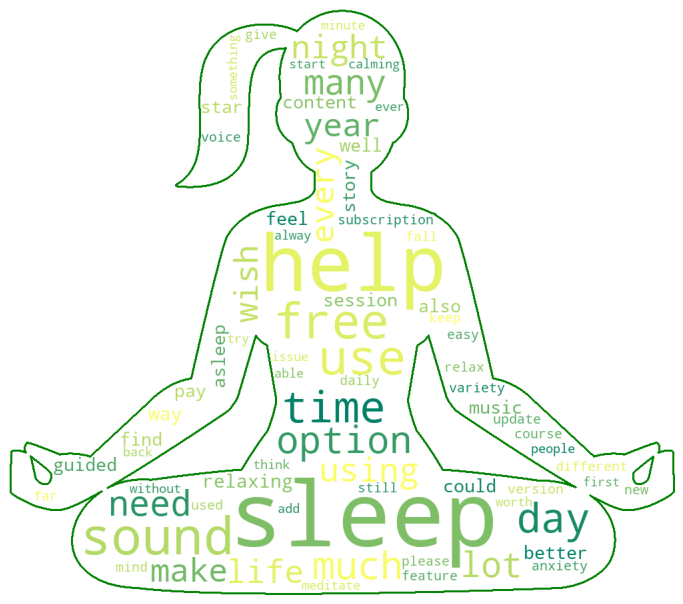

In [161]:
# Generate positive wordcloud for multi-class sentiment
multi_pos_tokens = wordcloud_prep(multi_pos_df['content'], stopwords_list)
multi_pos_wc = generate_wordcloud(multi_pos_tokens, stopwords_list, 
                                  colormap='summer', background_color='white', 
                                  contour_color='green')

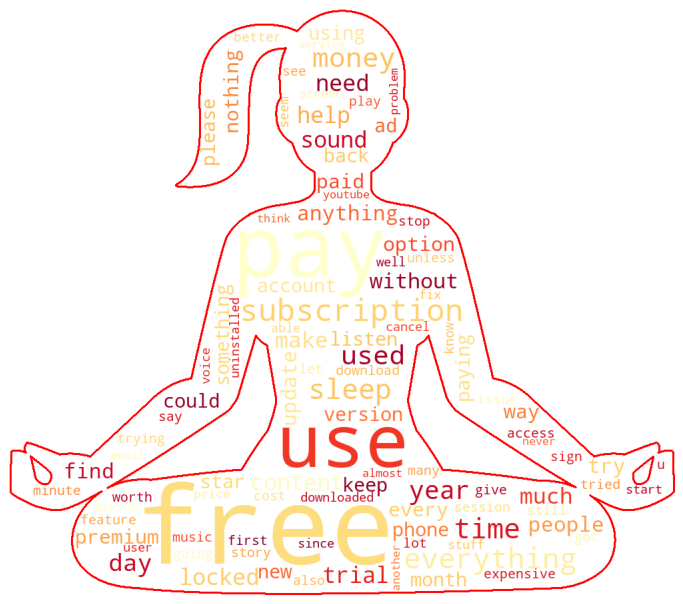

In [162]:
# Generate negative wordcloud for multi-class sentiment
multi_neg_tokens = wordcloud_prep(multi_neg_df['content'], stopwords_list)
multi_neg_wc = generate_wordcloud(multi_neg_tokens, stopwords_list, 
                                  colormap='YlOrRd', background_color='white', 
                                  contour_color='red')

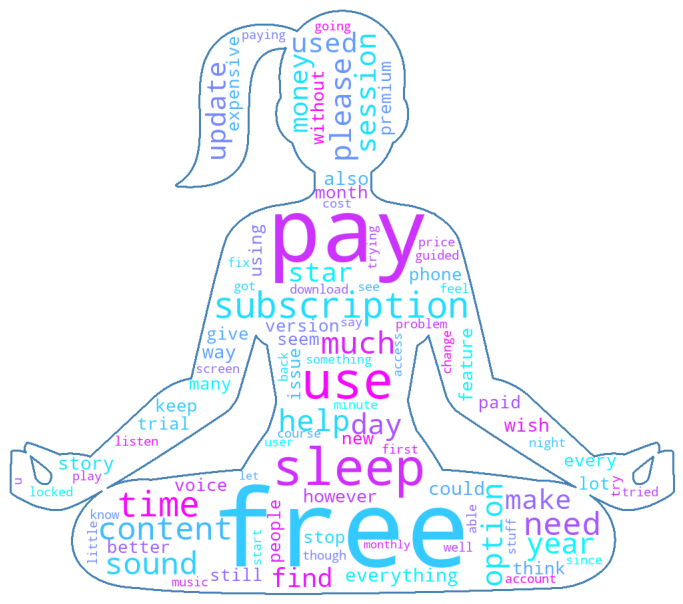

In [163]:
# Generate neutral wordcloud for multi-class sentiment
multi_neut_tokens = wordcloud_prep(multi_neut_df['content'], 
                                   stopwords_list)
multi_neut_wc = generate_wordcloud(multi_neut_tokens, stopwords_list, 
                                   colormap='cool', background_color='white')

The positive and neutral wordclouds that we see above indicate that there are a variety of topics that users write about in their reviews. Note that we can see sleep again seems to be one of the more important topics for neutral and positive reviews. However, it's much more obvious for the negative wordcloud that the majority of dissatisfaction that users have is either payment or customer-support related.

### Binary Sentiment WordClouds
Let's take a look at whether our results differ when we split our data into two classes as opposed to three.

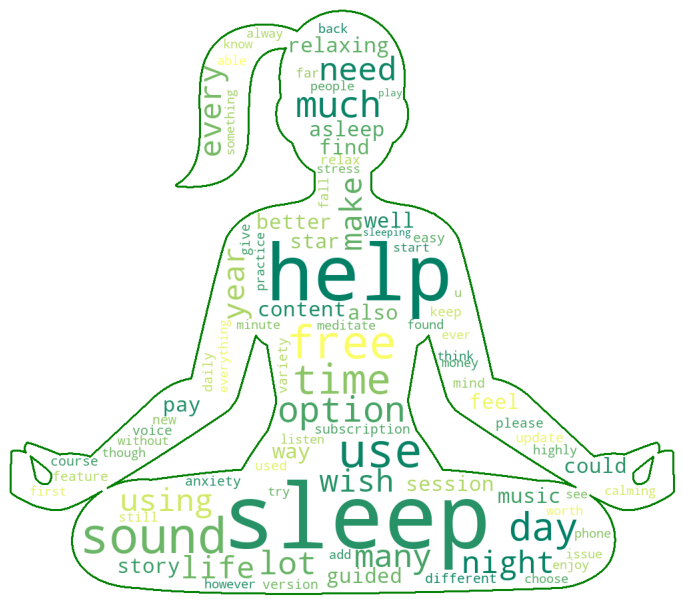

In [164]:
# Generate positive wordcloud for binary sentiment
bin_pos_tokens = wordcloud_prep(bin_pos_df['content'], stopwords_list)
bin_pos_wc = generate_wordcloud(bin_pos_tokens, stopwords_list, 
                                colormap='summer', background_color='white', 
                                contour_color='green')

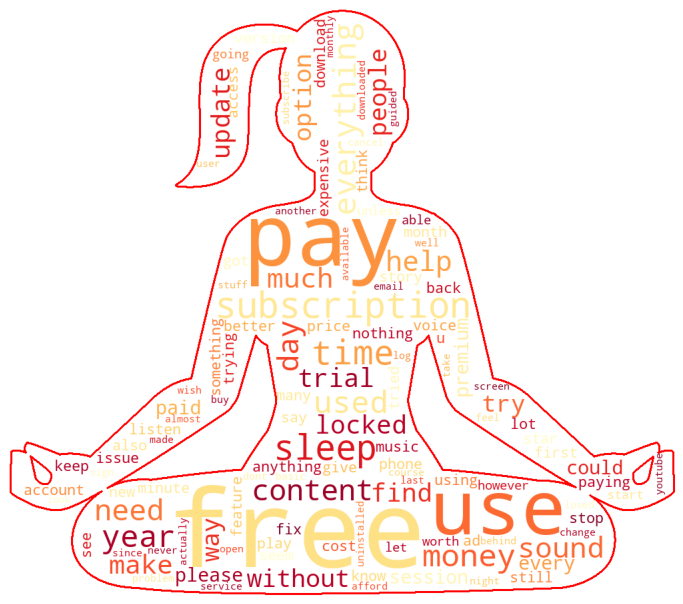

In [165]:
# Generate negative wordcloud for binary sentiment
bin_neg_tokens = wordcloud_prep(bin_neg_df['content'], stopwords_list)
bin_neg_wc = generate_wordcloud(bin_neg_tokens, stopwords_list, 
                                colormap='YlOrRd', background_color='white', 
                                contour_color='red')

Again, we can see that our negative wordcloud contains lots of payment and customer-support related topics, but our positive wordcloud doesn't as clearly tell us what app features users appreciated. Not to worry though, since our modeling and interpretation should give us more accurate insight into what is considered positive or negative.

# MODEL

In [166]:
# Model evaluation function
def evaluate_model(y_test, y_train, X_test, X_train, clf, n_class=3, 
                   figsize=(10,5), digits=2, params=False):
    """
    Displays evaluation metrics including classification report, confusion
    matrix, ROC-AUC curve.
    
    If the argument 'params' is passed, will display a table of the 
    parameters hyperparameters used in the model.

    Args:
        y_test (Series) : Testing data with target variable.
        y_train (Series) : Training data with target variable.
        X_test (DataFrame) : Testing data with vectorized feature variables.
        X_train (DataFrame) : Training data with vectorized feature variables.
        clf (classifier object) : Type of classificatier model to use.
        n_class (int) : Number of classes for classification task.
        figsize (int, int) : Figure dimensions. Default is (10,5)
        digits (int) : Number of decimal places to display in classification
                       report
        params (bool) : Prints table of hyperparameters used in model.
        
    Returns:
    
    """

    sns.set_style('dark')

    # Get Predictions
    y_hat_test = clf.predict(X_test)
    
    # Display training and test accuracy
    print("****TRAIN VS TEST ACCURACY****")
    print("\n", f"Training Score: {round(clf.score(X_train, y_train),2)}", 
          "\n", f"Test Score: {round(clf.score(X_test, y_test),2)}", "\n")
    
    # Display classification report
    print("****CLASSIFICATION REPORT - TEST DATA****")
    print(metrics.classification_report(y_test, y_hat_test, digits=digits))
    print("****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****")
    
    if n_class == 3:
        # Create a figure/axes for confusion matrix and ROC curve
        fig, ax = plt.subplots(ncols=2, figsize=figsize)

        # Plot confusion matrix
        plot_confusion_matrix(estimator=clf, X=X_test, y_true=y_test, 
                              cmap='Purples', normalize='true', ax=ax[0], 
                              display_labels=['Negative', 'Neutral', 
                                              'Positive'])
        ax[0].set_title('Confusion Matrix')
        
        # Plot ROC-AUC curve
        pred_prob = clf.predict_proba(X_test)
        fpr={}
        tpr={}
        thresh={}

        for i in range(n_class):    
            fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], 
                                                  pos_label=i)
            
        ax = ax[1]
        ax.grid()
        ax.plot(fpr[0], tpr[0], linestyle='-',color='red', label='Negative')
        ax.plot(fpr[1], tpr[1], linestyle='-',color='blue', label='Neutral')
        ax.plot(fpr[2], tpr[2], linestyle='-',color='green', label='Positive')
        ax.set_title('ROC-AUC curve')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive rate')
        ax.legend(loc='best')
        ax.plot([0,1], [0,1], ls='-', color='purple')

        plt.tight_layout()
        plt.show()

    elif n_class == 2:
        fig, axes = plt.subplots(ncols=2, 
                                 figsize=figsize)

        # Plot confusion matrix
        metrics.plot_confusion_matrix(clf, X_test,
                                      y_test,normalize='true',
                                      cmap='Purples',ax=axes[0],
                                      display_labels=['Negative', 'Positive'])
        axes[0].set_title('Confusion Matrix')

        # Plot ROC-AUC curve
        metrics.plot_roc_curve(clf,X_test,y_test,ax=axes[1])

        ax = axes[1]
        ax.plot([0,1],[0,1], ls='-', color='purple')
        ax.grid()
        ax.set_title('ROC-AUC Curve')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive rate')
        ax.get_legend().remove()

        plt.tight_layout()
        plt.show()
        
    # Print model parameters
    if params == True:
        print("****MODEL PARAMETERS****")
        params = pd.DataFrame(pd.Series(clf.get_params()))
        params.columns=['parameters']
        display(params)

## Multi-Class Modeling: [1-2] Negative, [3] Neutral, [4-5] Positive

### Vectorizing Train-Test Splits
We begin the modeling process by creating an X and y train-test split and then using a TF-IDF vectorizer to preprocess each document.

In [167]:
# Make X and y
y_multi = clean_df['multi_sent'].copy()
X = clean_df['content'].copy()

# Train Test Split
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(X, y_multi, 
                                                                            test_size=0.3, 
                                                                            random_state=27)

# Check y_train value counts
y_multi_train.value_counts(normalize=True)

2    0.496071
0    0.355293
1    0.148636
Name: multi_sent, dtype: float64

In [168]:
# Initialize RegExp tokenizer
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")

# Make a TF-IDF vectorizer
vectorizer_multi = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                                   token_pattern=r"([a-zA-Z]+(?:’[a-z]+)?)",
                                   stop_words=stopwords_list,
                                   ngram_range=(1,2))

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_multi_train_tfidf = vectorizer_multi.fit_transform(X_multi_train)
X_multi_test_tfidf = vectorizer_multi.transform(X_multi_test)
X_multi_train_tfidf

<30161x191871 sparse matrix of type '<class 'numpy.float64'>'
	with 566599 stored elements in Compressed Sparse Row format>

### Logistic Regression

In [71]:
# Fit Logistic Regression model on multi-class training data
logreg = LogisticRegression(max_iter=200, class_weight='balanced')
logreg.fit(X_multi_train_tfidf, y_multi_train)

LogisticRegression(class_weight='balanced', max_iter=200)

****TRAIN VS TEST ACCURACY****

 Training Score: 0.95 
 Test Score: 0.85 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      2347
           1       0.23      0.39      0.29       717
           2       0.96      0.89      0.92     10346

    accuracy                           0.85     13410
   macro avg       0.64      0.69      0.66     13410
weighted avg       0.88      0.85      0.86     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


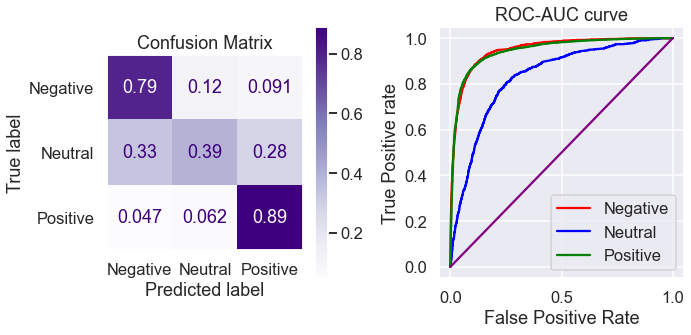

In [72]:
# Evaluate model performance
evaluate_model(y_multi_test, y_multi_train, 
               X_multi_test_tfidf, X_multi_train_tfidf, logreg)

Even without the help of a gridsearch, our Logistic Regression model already seems to have decent performance when it comes to classifying negative and positive sentiments. It does have much poorer performance classifying neutral sentiments, but this is understandable considering that the neutral sentiment wordcloud was also not able to give us much insight into what topics were associated with a neutral sentiment.

### Random Forest

In [73]:
# Fit Random Forest model on multi-class training data
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_multi_train_tfidf, y_multi_train)

RandomForestClassifier(class_weight='balanced')

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.84 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.88      0.44      0.59      2347
           1       0.50      0.00      0.01       717
           2       0.84      0.99      0.91     10346

    accuracy                           0.84     13410
   macro avg       0.74      0.48      0.50     13410
weighted avg       0.83      0.84      0.81     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


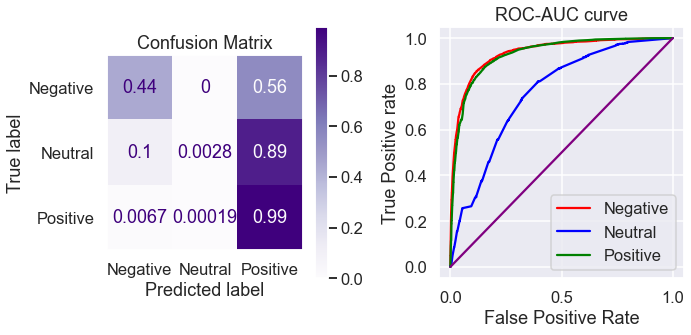

In [74]:
# Evaluate model performance
evaluate_model(y_multi_test, y_multi_train, X_multi_test_tfidf, 
               X_multi_train_tfidf, rf)

On our first iteration of a Random Forest model, we can see that the model is clearly being overfit to the training data, resulting in extremely poor recall scores for negative and neutral sentiments. Let's use a gridsearch to address this issue.

In [75]:
# Initialize Random Forest algorithm
rf = RandomForestClassifier(class_weight='balanced')

# Create hyperparameter grid to gridsearch
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [10, 20, 40],
              'n_estimators': [50, 100, 200],
              'min_samples_leaf': [2, 5, 10]}

# Initialize gridsearch optimized for F1 macro score
gridsearch = GridSearchCV(estimator=rf, param_grid = param_grid, 
                          scoring='f1_macro', n_jobs=-1)

# Run gridsearch and display best hyperparameters
gridsearch.fit(X_multi_train_tfidf,  y_multi_train)
gridsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 40,
 'min_samples_leaf': 2,
 'n_estimators': 200}

****TRAIN VS TEST ACCURACY****

 Training Score: 0.87 
 Test Score: 0.84 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.72      0.65      0.68      2347
           1       0.22      0.25      0.24       717
           2       0.91      0.92      0.91     10346

    accuracy                           0.84     13410
   macro avg       0.62      0.61      0.61     13410
weighted avg       0.84      0.84      0.84     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


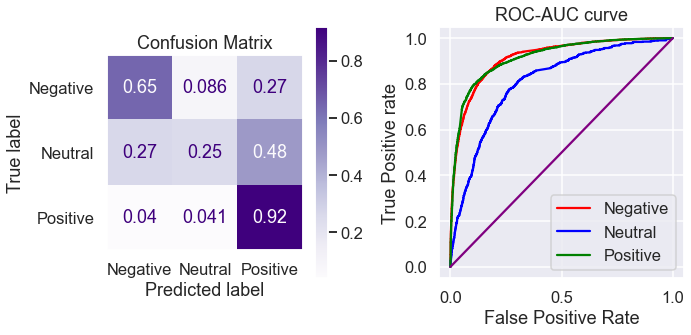

In [76]:
# Evaluate best model performance
evaluate_model(y_multi_test, y_multi_train, X_multi_test_tfidf, 
               X_multi_train_tfidf, gridsearch.best_estimator_)

Our gridsearched model's performance has improved considerably in classifying negative and neutral sentiments, but it still isn't quite ideal. Let's see if running another gridsearch can further improve performance.

In [77]:
# Initialize Random Forest algorithm
rf = RandomForestClassifier(class_weight='balanced')

# Create hyperparameter grid to gridsearch
param_grid = {'criterion': ['entropy'],
              'max_depth': [40, 60],
              'n_estimators': [200, 300],
              'min_samples_leaf': [5]}

# Initialize gridsearch optimized for F1 macro score
gridsearch = GridSearchCV(estimator=rf, param_grid = param_grid, 
                          scoring='f1_macro', n_jobs=-1)

# Run gridsearch and display best hyperparameters
gridsearch.fit(X_multi_train_tfidf,  y_multi_train)
gridsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 60,
 'min_samples_leaf': 5,
 'n_estimators': 300}

****TRAIN VS TEST ACCURACY****

 Training Score: 0.84 
 Test Score: 0.82 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      2347
           1       0.21      0.38      0.27       717
           2       0.92      0.89      0.91     10346

    accuracy                           0.82     13410
   macro avg       0.62      0.64      0.62     13410
weighted avg       0.85      0.82      0.83     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


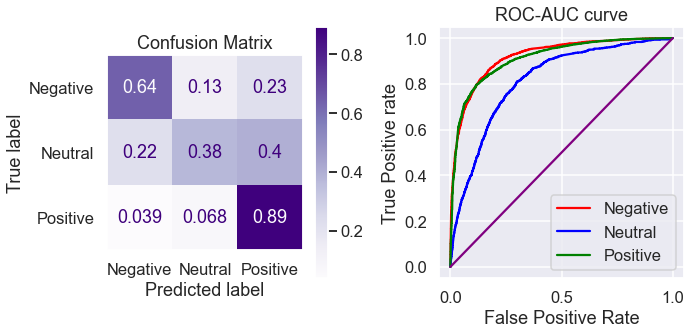

In [78]:
# Evaluate best model performance
evaluate_model(y_multi_test, y_multi_train, 
               X_multi_test_tfidf, X_multi_train_tfidf, 
               gridsearch.best_estimator_)

We do see some improvement in the model's ability to correctly predict neutral sentiment, but this comes at the cost of our negative and positive sentiment recall scores. Hence, we conclude that the Logistic Regression algorithm is a much better choices than the Random Forest algorithm for our task.

## Binary Modeling: [1-3] Negative,  [4-5] Positive

Here, we return to our binary classification problem where ratings of 1-3 stars will be considered to be negative, and 4-5 star ratings will be considered to be positive.

### Vectorizing Train-Test Splits

Similar to the multi-class modeling problem, we will vectorize the data following its new train-test split.

In [79]:
# Make y
y_bin = clean_df['sent_bin_4up'].copy()

## Train Test Split
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X, y_bin, 
                                                                    test_size=0.3, 
                                                                    random_state=27)

# Check y_train value counts
y_bin_train.value_counts(normalize=True)

1    0.77493
0    0.22507
Name: sent_bin_4up, dtype: float64

In [80]:
# Make a TF-IDF vectorizer using previously created tokenizer
vectorizer_bin = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                                 token_pattern=r"([a-zA-Z]+(?:’[a-z]+)?)",
                                 stop_words=stopwords_list,
                                 ngram_range=(1,2))

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_bin_train_tfidf = vectorizer_bin.fit_transform(X_bin_train)
X_bin_test_tfidf = vectorizer_bin.transform(X_bin_test)
X_bin_train_tfidf

<31288x310249 sparse matrix of type '<class 'numpy.float64'>'
	with 1030078 stored elements in Compressed Sparse Row format>

### Logistic Regression
Again, let's start modeling for our binary classification problem with Logistic Regression.

In [81]:
# Fit Logistic Regression model on binary training data
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_bin_train_tfidf, y_bin_train)

LogisticRegression(class_weight='balanced')

****TRAIN VS TEST ACCURACY****

 Training Score: 0.94 
 Test Score: 0.89 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      3064
           1       0.96      0.90      0.93     10346

    accuracy                           0.89     13410
   macro avg       0.84      0.88      0.86     13410
weighted avg       0.90      0.89      0.90     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


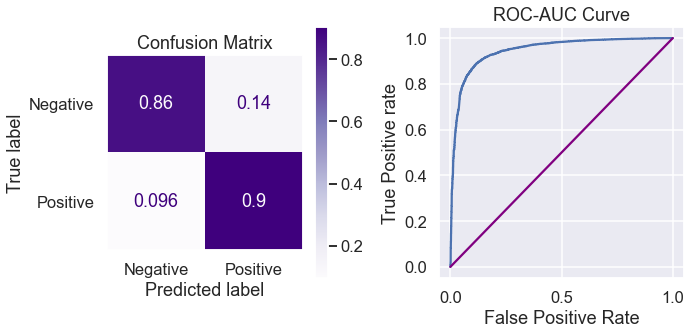

In [82]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, logreg, 2)

Right off the bat, we see great performance with our Logistic Regression algorithm. Again, due to hardware limitations we will not gridsearch this model. Although the model does seem to be slightly overfitting to the training data, it is not overfitting by a large amount. We can see that our F1 score is 0.86 for negative classification and .90 for positive classification, which is quite good. 

In [83]:
# Fit Logistic Regression model on binary training data
logregcv = LogisticRegressionCV(max_iter=750, class_weight='balanced')
logregcv.fit(X_bin_train_tfidf, y_bin_train)

LogisticRegressionCV(class_weight='balanced', max_iter=750)

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.9 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      3064
           1       0.95      0.93      0.94     10346

    accuracy                           0.90     13410
   macro avg       0.86      0.88      0.87     13410
weighted avg       0.91      0.90      0.91     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


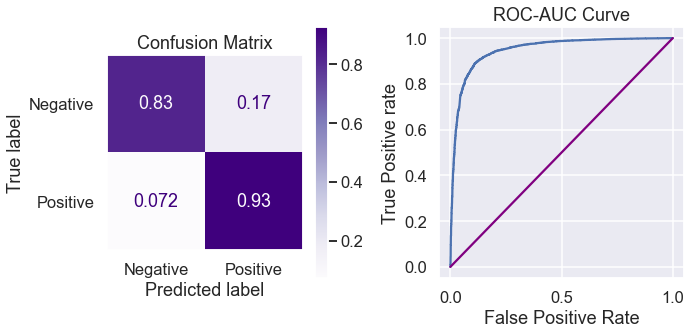

In [84]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, logregcv, 2)

We see that although this model has higher predictive capability on positive sentiment, it comes at the cost of a lower recall score for negative sentiment, as well as a more overfit model than we saw before. In order to preserve a more even prediction rate between negative and positive sentiments, we will proceed with the non-cross-validated version of Logistic Regression as our best model.

### Random Forest

In [85]:
# Fit Random Forest model on binary training data
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_bin_train_tfidf, y_bin_train)

RandomForestClassifier(class_weight='balanced')

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.88 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.88      0.54      0.67      3064
           1       0.88      0.98      0.93     10346

    accuracy                           0.88     13410
   macro avg       0.88      0.76      0.80     13410
weighted avg       0.88      0.88      0.87     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


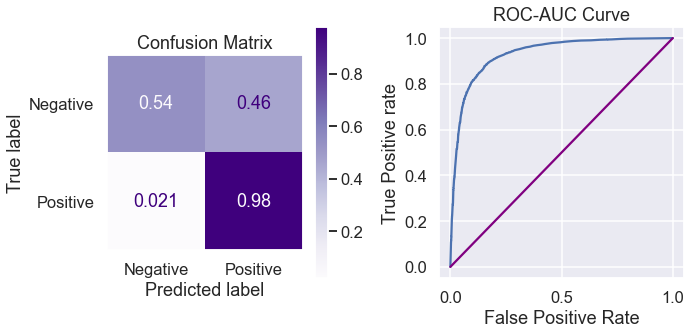

In [86]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, rf, 2)

Because we haven't altered any of the hyperparameters for our Random Forest algorithm, we again see that our modelling is clearly overfitting to the training data. Let's run a few gridsearches on this model.

In [87]:
# Initialize Random Forest algorithm
rf = RandomForestClassifier(class_weight='balanced')

# Create hyperparameter grid to gridsearch
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [10, 20, 30, 40],
              'min_samples_leaf': [3, 5, 7]}

# Initialize gridsearch optimized for F1 macro score
gridsearch = GridSearchCV(estimator=rf, param_grid = param_grid, 
                          scoring='f1_macro', n_jobs=-1)

# Run gridsearch and display best hyperparameters
gridsearch.fit(X_bin_train_tfidf,  y_bin_train)
gridsearch.best_params_

{'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 3}

****TRAIN VS TEST ACCURACY****

 Training Score: 0.87 
 Test Score: 0.87 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      3064
           1       0.91      0.92      0.91     10346

    accuracy                           0.87     13410
   macro avg       0.81      0.81      0.81     13410
weighted avg       0.86      0.87      0.86     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


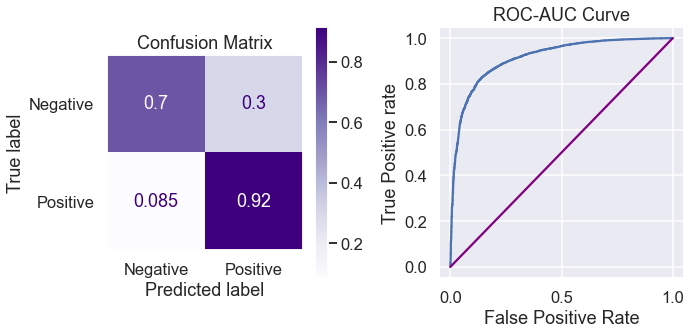

In [88]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, 
               gridsearch.best_estimator_, 2)

Great! We have addressed the issue of overfitting. Our model is performing much better on the negative classification, and only a little worse on the positive classification. Let's see if we can further improve our gridsearch performance.

In [89]:
# Initialize Random Forest algorithm
rf = RandomForestClassifier(class_weight='balanced')

# Create hyperparameter grid to gridsearch
param_grid = {'criterion': ['entropy'], 
              'max_depth': [40, 50, 60],
              'min_samples_leaf': [1, 2, 3]}

# Initialize gridsearch optimized for F1 macro score
gridsearch = GridSearchCV(estimator=rf, param_grid = param_grid, 
                          scoring='f1_macro', n_jobs=-1)

# Run gridsearch and display best hyperparameters
gridsearch.fit(X_bin_train_tfidf,  y_bin_train)
gridsearch.best_params_

{'criterion': 'entropy', 'max_depth': 60, 'min_samples_leaf': 1}

****TRAIN VS TEST ACCURACY****

 Training Score: 0.95 
 Test Score: 0.88 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.80      0.64      0.71      3064
           1       0.90      0.95      0.93     10346

    accuracy                           0.88     13410
   macro avg       0.85      0.80      0.82     13410
weighted avg       0.88      0.88      0.88     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


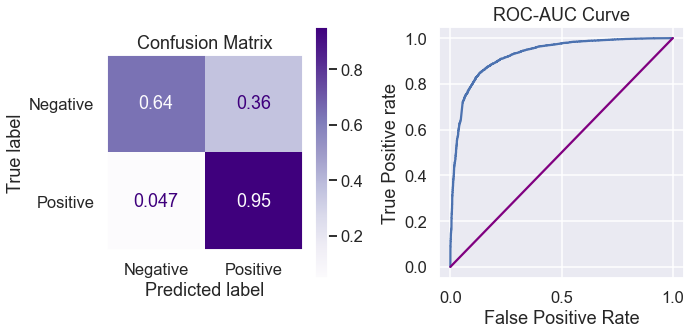

In [90]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, 
               gridsearch.best_estimator_, 2)

Again, we can see that we are already overfitting to the training data again, and the model's overall performance is already getting worse.

### Support Vector Classification

Because our vectorized bag of words has a much higher number of columns than rows, we can expect our Support Vector Classification model to performan well.

In [91]:
# Fit SVC model on binary training data
svc = LinearSVC()
svc.fit(X_bin_train_tfidf, y_bin_train)

LinearSVC()

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.91 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      3064
           1       0.93      0.95      0.94     10346

    accuracy                           0.91     13410
   macro avg       0.87      0.86      0.87     13410
weighted avg       0.91      0.91      0.91     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


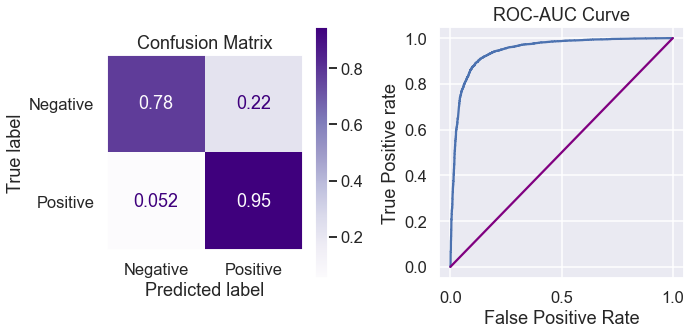

In [92]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, svc, 2)

Without altering the model's hyperparameters, we can already see decent performance, with positive classification performing slightly better than our Logistic Regression, and negative classification doing slightly worse. Let's use a gridsearch to see if we can improve the model's performance.

In [93]:
# Initialize SVC algorithm
svc = LinearSVC(class_weight='balanced')

# Create hyperparameter grid to gridsearch
param_grid = {'penalty': ['l1', 'l2'],
              'loss': ['hinge', 'squared_hinge'],
              'tol': [0.000001, 0.0001, 0.01],
              'C': [0.1, 1, 10], 
              'fit_intercept': [True, False]}

# Initialize gridsearch optimized for F1 macro score
gridsearch = GridSearchCV(estimator=svc, param_grid = param_grid, 
                          scoring='f1_macro', n_jobs=-1)

# Run gridsearch and display best hyperparameters
gridsearch.fit(X_bin_train_tfidf,  y_bin_train)
gridsearch.best_params_

{'C': 1, 'fit_intercept': True, 'loss': 'hinge', 'penalty': 'l2', 'tol': 1e-06}

****TRAIN VS TEST ACCURACY****

 Training Score: 0.98 
 Test Score: 0.9 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      3064
           1       0.95      0.92      0.94     10346

    accuracy                           0.90     13410
   macro avg       0.85      0.88      0.87     13410
weighted avg       0.91      0.90      0.90     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


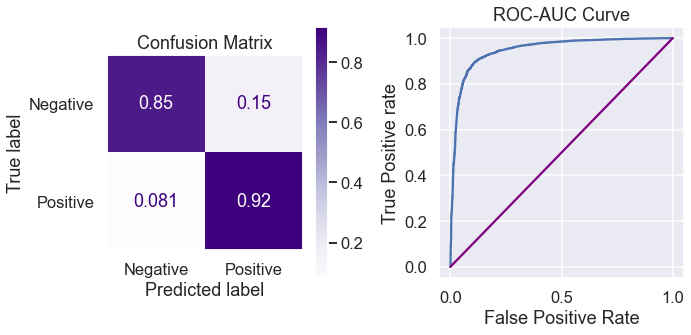

In [94]:
# Evaluate best model's performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, 
               gridsearch.best_estimator_, 2)

### Best Model Summary

By observing the evaluation metrics from each of our models, we can see that the binary classification models had much better performance. We will still examine the feature coefficients found in our Multi-Class Logistic Regression as a reference point, but for extracting final insights, we will make use of our Binary Logistic Regression and SVC models. Below, we can find a roundup of each model's performance metrics along with their fit times.

#### Multi-Class Logistic Regression

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
****TRAIN VS TEST ACCURACY****

 Training Score: 0.95 
 Test Score: 0.85 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      2347
           1       0.23      0.39      0.29       717
           2       0.96      0.89      0.92     10346

    accuracy                           0.85     13410
   macro avg       0.64      0.69      0.66     13410
weighted avg       0.88      0.85      0.86     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


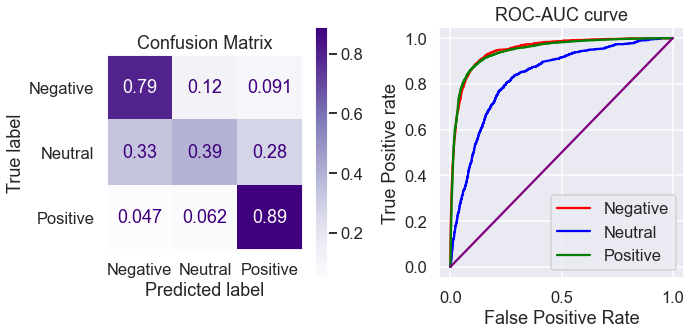

In [95]:
# Fit best performing Logistic Regression on multi-class data
# and display performance
%time
best_multi_lr = LogisticRegression(max_iter=200, class_weight='balanced')
best_multi_lr.fit(X_multi_train_tfidf, y_multi_train)
evaluate_model(y_multi_test, y_multi_train, 
               X_multi_test_tfidf, X_multi_train_tfidf, best_multi_lr)

#### Binary Logistic Regression

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
****TRAIN VS TEST ACCURACY****

 Training Score: 0.94 
 Test Score: 0.89 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      3064
           1       0.96      0.90      0.93     10346

    accuracy                           0.89     13410
   macro avg       0.84      0.88      0.86     13410
weighted avg       0.90      0.89      0.90     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


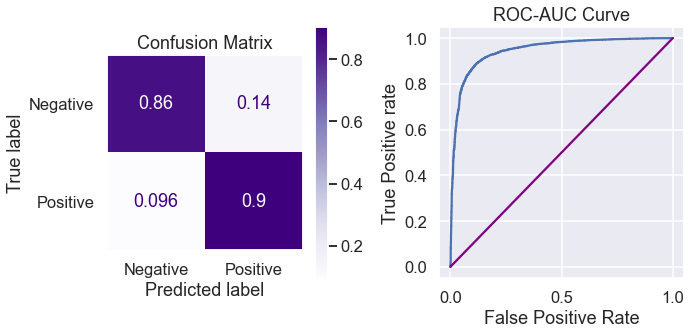

In [96]:
# Fit best performing Logistic Regression on binary data
# and display performance
%time
best_bin_lr = LogisticRegression(class_weight='balanced')
best_bin_lr.fit(X_bin_train_tfidf, y_bin_train)
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, best_bin_lr, 2)

We can see that there is a small difference in training times between these models.

### Evaluating Feature Importances to Sentiment Classification

Here, we provide a summary of visualizations that can help us determine what words are indicative of either positive or negative sentiments. We first revisit our wordclouds to remind ourselves what words are frequently found in negative and positive sentiments, then move on to examine feature coefficients from our Logistic Regression models.

##### Revisiting Multi-Class WordClouds

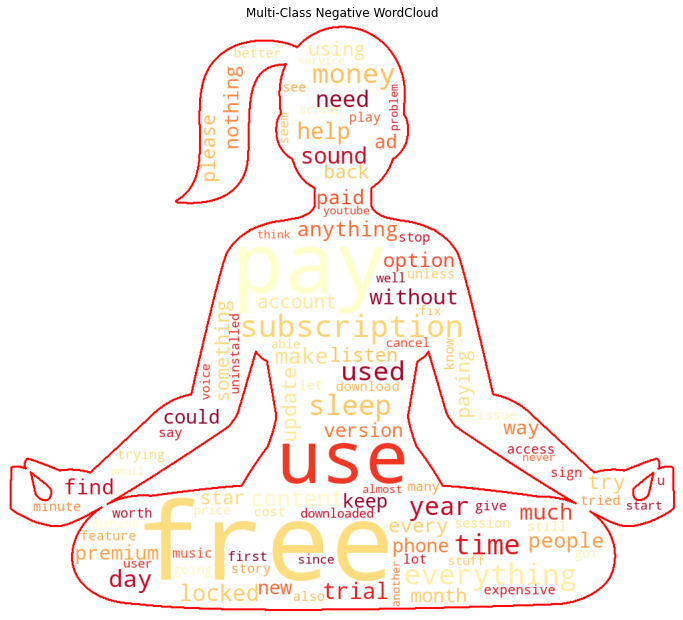

In [169]:
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(multi_neg_wc) 
plt.title('Multi-Class Negative WordCloud')
plt.axis('off');

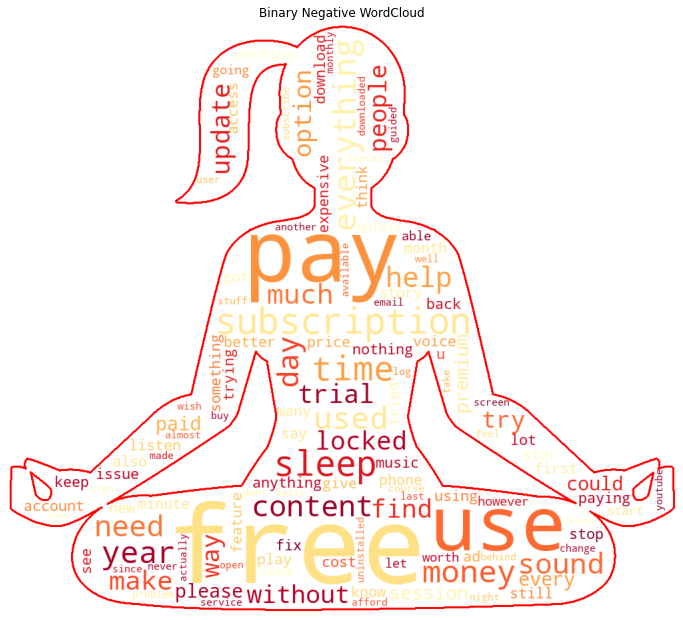

In [170]:
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(bin_neg_wc) 
plt.title('Binary Negative WordCloud')
plt.axis('off');

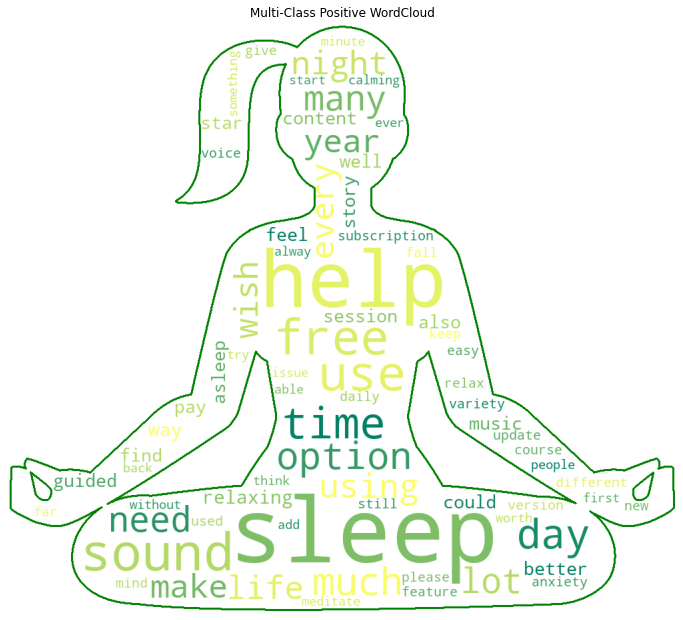

In [171]:
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(multi_pos_wc) 
plt.title('Multi-Class Positive WordCloud')
plt.axis('off');

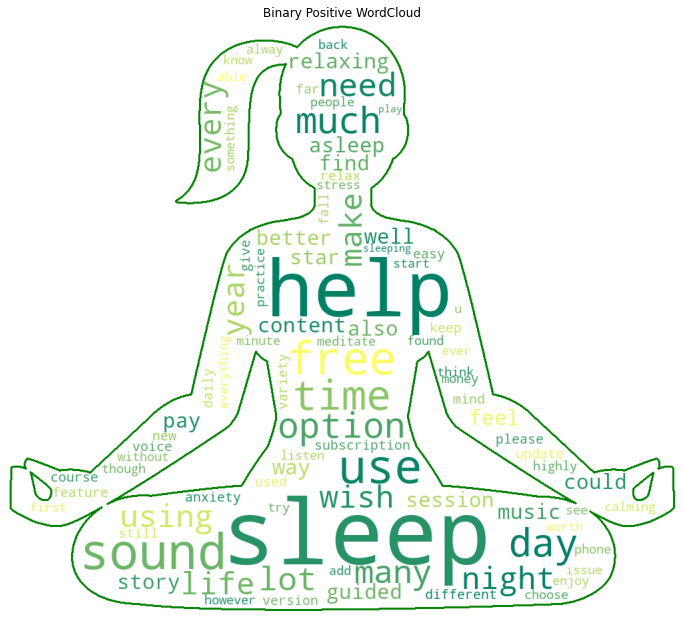

In [172]:
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(bin_pos_wc) 
plt.title('Binary Positive WordCloud')
plt.axis('off');

#### Model Feature Coefficient Analysis

Now let's compare how the insights from our models compare to these wordclouds.

In order to easily visualize what words had a heavier impact on the classification tasks, we will create barplots of the feature coefficients. For Logistic Regression, our units are in log odds, and so we can use the resulting visuals to get an idea of how much importance certain words relative to other words.

##### Extracting Coefficients

In [101]:
# Extract coefficients for negative classification from multi-class LogReg model
feature_names_multi = vectorizer_multi.get_feature_names()
log_coeff_multi = pd.Series(best_multi_lr.coef_[0], 
                            index=feature_names_multi).sort_values(ascending=False)
lr_multi_neg = log_coeff_multi.head(30)
lr_multi_neg

waste           4.149088
pay             3.930401
scam            3.911700
refund          3.752736
nothing         3.589443
useless         3.360529
money           3.357976
cancel          3.322177
charged         3.271018
free            3.228345
paid            3.165171
youtube         3.060643
deleted         3.060080
even            2.959672
anything        2.938652
response        2.908503
charge          2.851537
service         2.808596
trial           2.759657
can’t           2.556559
used            2.437097
unless          2.404335
downloaded      2.376491
subscription    2.364908
waste time      2.360954
another         2.343165
account         2.250450
support         2.167510
ridiculous      2.138987
tried           2.107287
dtype: float64

In [102]:
# Extract coefficients for neutral classification from multi-class LogReg model
log_coeff_multi = pd.Series(best_multi_lr.coef_[1], 
                            index=feature_names_multi).sort_values(ascending=False)
lr_multi_neut = log_coeff_multi.head(30)
lr_multi_neut

wish             3.306832
however          3.296086
needs            3.156431
okay             2.619824
pay              2.542509
locked           2.497298
update           2.487984
things           2.481749
it’s ok          2.349625
doesn’t          2.262670
notifications    2.238217
ok               2.211682
please           2.204475
premium          2.168191
three stars      2.163153
three            2.141338
meh              2.141167
could better     2.109335
though           2.084982
alright          2.053412
sometimes        2.012195
it’s calming     2.008919
mostly           1.985532
think            1.960752
rest             1.955075
distracting      1.944241
ss               1.922132
joann            1.922132
fatima           1.905458
coaching         1.892594
dtype: float64

In [103]:
# Extract coefficients for positive classification from multi-class LogReg model
log_coeff_multi = pd.Series(best_multi_lr.coef_[2], 
                            index=feature_names_multi).sort_values(ascending=False)
lr_multi_pos = log_coeff_multi.head(30)
lr_multi_pos

life          4.564987
easy          3.136781
highly        3.133140
day           2.680304
mind          2.511738
feel          2.323330
definitely    2.298280
far           2.192939
lot           2.190680
didn’t pay    2.135592
ever          2.050639
truly         2.039540
grateful      2.026560
absolutely    1.929679
anxiety       1.907714
feelings      1.875360
friend        1.843545
meditation    1.818306
everyday      1.795276
i’ve          1.792564
practice      1.752999
feeling       1.727808
asleep        1.726594
happy         1.698626
gives         1.682562
night         1.649463
fun           1.619550
diary         1.610030
positive      1.570776
relaxed       1.561558
dtype: float64

In [104]:
# Extract coefficients for positive classification from binary LogReg model
feature_names_bin = vectorizer_bin.get_feature_names()
log_coeff_bin = pd.Series(best_bin_lr.coef_.flatten(), 
                          index=feature_names_bin).sort_values(ascending=False)
lr_bin_pos = log_coeff_bin.head(22)
lr_bin_pos

life          6.675193
easy          4.320892
highly        4.144591
day           4.031501
feel          3.533113
far           3.494255
definitely    3.296762
mind          3.275490
lot           3.157402
feelings      2.989367
grateful      2.850748
truly         2.838214
meditation    2.760275
didn’t pay    2.700208
i’ve          2.595948
feeling       2.559657
asleep        2.510027
everyday      2.506764
anxiety       2.504001
friend        2.476129
habits        2.455346
night         2.428035
dtype: float64

In [105]:
# Extract coefficients for negative classification from binary LogReg model
lr_bin_neg = log_coeff_bin.tail(22)
lr_bin_neg

refund         -4.147979
paying         -4.158967
useless        -4.185140
charge         -4.238370
service        -4.249729
frustrating    -4.288553
scam           -4.348352
waste          -4.404109
crashes        -4.414699
trial          -4.461804
cancel         -4.746034
subscription   -4.789707
nothing        -5.263785
can’t          -5.267615
deleted        -5.293287
doesn’t        -5.322337
update         -5.366532
locked         -5.800127
charged        -5.837720
free           -6.670681
money          -7.534205
pay            -9.175482
dtype: float64

##### Multi-Class Logistic Regression Coefficients

In [106]:
# Create function to create barplots using feature coefficients
def barplot_series(series, title, xlabel, ylabel, palette='cool'):
    """
    Displays barplot of input series.
    
    If the argument 'params' is passed, will display a table of the 
    parameters hyperparameters used in the model.

    Args:
        series (Series) : Series containing data to visualize.
        title (str) : Title of plot.
        xlabel (str) : X axis title.
        ylabel (str) : y axis title.
        palette : Color palette to create plot using.
        
    Returns:
    
    """
    # Create bar plot of feature coefficients as odds.
    fig, ax = plt.subplots(figsize=(10,10))

    sns.barplot(x=series.values, y=series.index, palette=palette, 
              ax=ax, orient='h')

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);

In [107]:
# Set Seaborn style
sns.set_style('darkgrid')

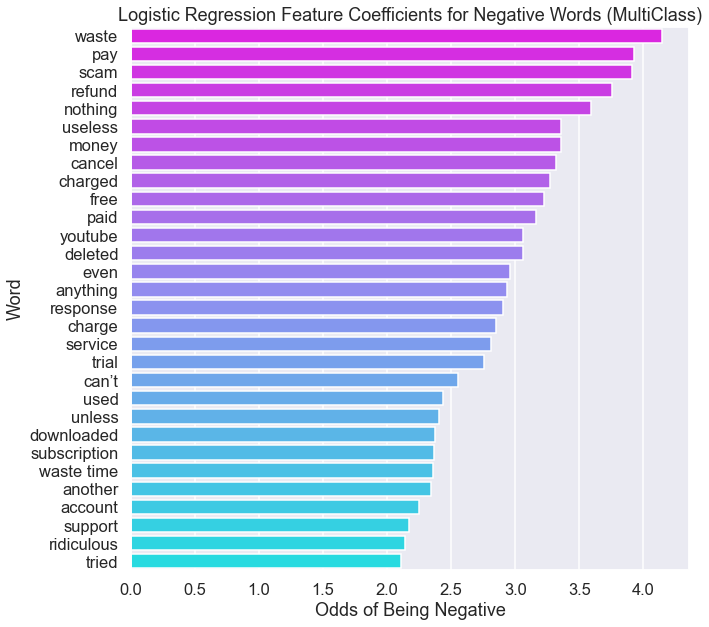

In [108]:
# Create bar plot of feature coefficients for multiclass negative as log odds
barplot_series(lr_multi_neg, 
               "Logistic Regression Feature Coefficients for Negative Words (MultiClass)", 
               "Odds of Being Negative", "Word", palette='cool_r')

Our Multi-Class negative sentiment coefficients indicate with words such as "pay", "money", "charged", "free", "charge" and "subscription" that users are mostly unhappy about the costs that are involved in using the app. We can also see from words including "scam", "refund", "cancel", "service", "account" and "support" that it is likely that a lot of negative reviews are related to customer support.

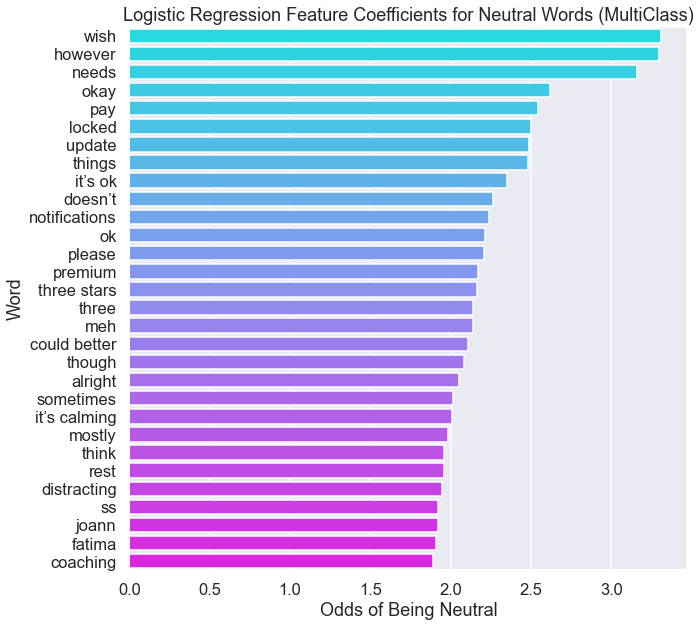

In [109]:
# Create bar plot of feature coefficients for multiclass neutral as log odds
barplot_series(lr_multi_neut, 
               "Logistic Regression Feature Coefficients for Neutral Words (MultiClass)", 
               "Odds of Being Neutral", "Word")

We can see that our model seems to have extracted words that indeed indicate what topics are related to a neutral review. However, this information is not so crucial to our analysis.

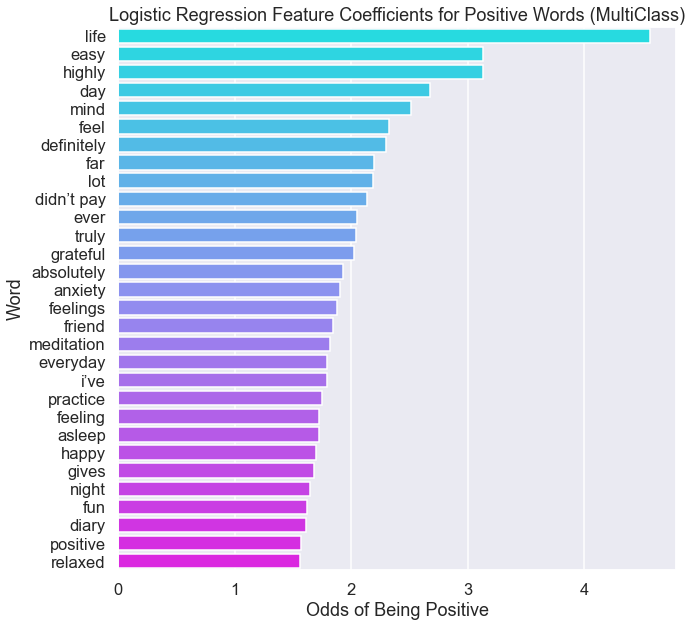

In [110]:
# Create bar plot of feature coefficients for multiclass positive as log odds
barplot_series(lr_multi_pos, 
               "Logistic Regression Feature Coefficients for Positive Words (MultiClass)", 
               "Odds of Being Positive", "Word")

For multi-class positive classification, we can see from the words "asleep" and "night" that sleep functionality is considered a positive element of the app. We also see from the words "easy", "day", "everyday" and "diary" that users appreciate ease of use that enables people to use the app regularly.

Now that we have a general idea of what words are associated with negative and positive sentiments, let's move on to examine whether our binary classification model confirms our findings.

##### Binary Logistic Regression Coefficients


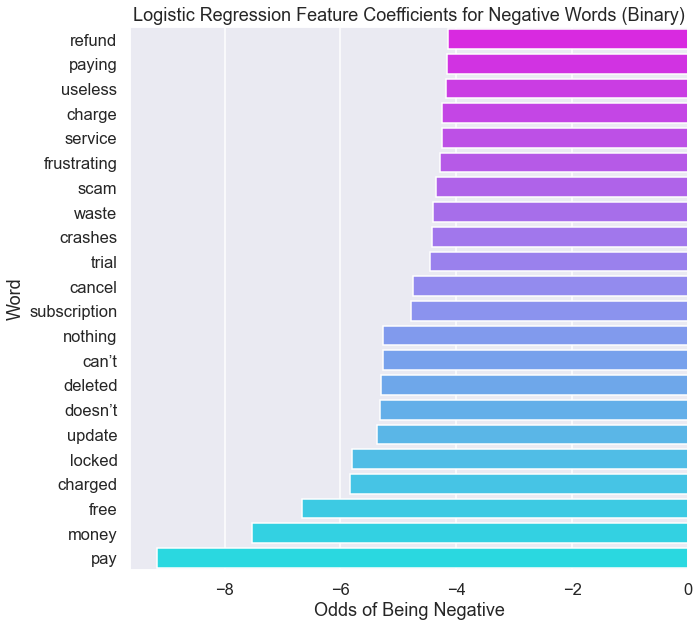

In [111]:
# Create bar plot of feature coefficients for binary negative as log odds
barplot_series(lr_bin_neg, 
               "Logistic Regression Feature Coefficients for Negative Words (Binary)", 
               "Odds of Being Negative", "Word", 'cool_r')

Our binary Logistic Regression confirms that payment is a major issue, and through the words "response" and "crashes" further reinforces that customer support is also something to consider while addressing negative reviews.

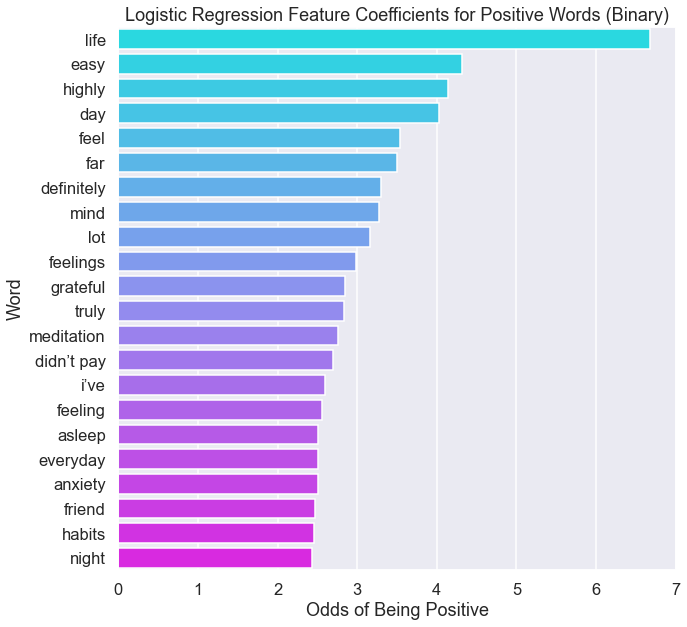

In [112]:
# Create bar plot of feature coefficients for binary positive as log odds
barplot_series(lr_bin_pos, 
               "Logistic Regression Feature Coefficients for Positive Words (Binary)", 
               "Odds of Being Positive", "Word")

For positive sentiments, we see another key indicator word "habits" which further illustrates that users appreciate being able to make the app a regular part of their routine. We also see the words "night" and "asleep", which confirm that sleep functionality is considered a highly positive app feature.

Topics are highly correlated with negative
sentiment

• Payment and costs • Sleep-aid functionality

Topics are highly correlated with Positive
sentiment

• Technical and customer support • Ease-of-use and regular use

Now that we have gained insight into what elements to focus on when developing a new mental
health app, we can compare it with existing apps. The following are my recommendations:
1. Because payment and charges appear to be a recurring theme in bad reviews, app
pricing and subscription fees must be carefully considered. Many reviews expressed
dissatisfaction with the app's "free" element, implying that users were misled. We
should solve this problem by making it clear at the time of download which aspects of
the app are free and which are only available to premium subscribers.
2. Appropriate resources should be allocated to adequately educating the customer service
crew. Users were dissatisfied when their app failed, as well as when their payment
difficulties were not fixed effectively. We should ensure that customer service
representatives are properly trained to diagnose both technical and payment-related
difficulties that consumers may encounter.
3. Invest in R&D of the app's sleep-aid functionality. Sleep-related phrases were
connected with happy emotions by users, demonstrating how an app's capacity to serve
as a trustworthy sleeping aid might affect users' mental health.
4. Develop the app's UI thoroughly to make it appealing and simple to use. Users are more
likely to relate ease-of-use and the possibility to make using the app a habit with
pleasant feelings, therefore UI/UX designers should take this into consideration.
Some limitations and ideas for further analysis include:
1. Since we don't have any pricing data for apps, we could further investigate the pricing
of subscriptions and app costs to determine what the best pricing scheme would be.
2. The data we have is limited to reviews and ratings on the Google Play Store. We can
get a better sense of a mobile app's sentiment if we collect and analyse reviews from
the Apple App Store.
3. Possible Implementation Recurrent neural network (RNN) based on the long short-term
memory (LSTM) modeling in order to gain a better understanding of what topics appear
in both positive and negative reviews.